In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2024 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Rafael Flock (DTU)
#  Edited by: Chao Zhang (DTU)
#  Reviewed by: Jakob Sauer Jørgensen (DTU)

# UQ for stochastic optical reconstruction microscopy

### Rafael Flock (raff@dtu.dk)

In this case study, we perform uncertainty quantification for the problem of stochastic optical reconstruction microscopy (STORM). STORM is a super-resolution microscopy method based on single-molecule stochastic switching, where the goal is to detect molecule positions in live cell imaging. The image is obtained by a microscope detecting the photon count of the (fluorescence) photoactivated molecules. The original problem is solved in [1] by a determistic method. In this notebook, we perform uncertainty quantification in the Bayesian context [2].


In [2]:
import numpy as np
from scipy.stats import lognorm, norm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import cuqi
from cuqi.distribution import Laplace, Gaussian, JointDistribution
from cuqi.problem import BayesianProblem

## 1. Problem description

We start by collecting parameters that we will use later in our experiment in a dictionary.

In [3]:
# parameters
par = \
{'N': 50, # number of molecules
 's_data': 32, # side length of data image
 's_mol': 24, # side length of area in data image where molecules are located
 'R': 4, # super-resolution factor
 'mode': 3000, # mode of lognormal distribution of molecule photon count
 'ph_back': 70, # photon background count
 'noise_std': 30, # standard deviation of noise
 'pad_width': 1, # for boundary conditions of blurring kernel of instrument
 'ext_mode': 'periodic', # boundary condition of blurring kernel
 'lognorm_std': 0.417, # standard deviation of lognormal distribution of photon count
 'ind_mol_seed': 0, # seed for generation of true molecule positions
 'N_pho_seed': 1, # seed for generation of true photon count of molecules
 'noise_seed': 2, # seed for noise
 'delta': 1.275, # rate parameter of Laplace prior
}

We also define two functions that help us to switch between image and vector view of our data.

In [4]:
# ravel/unravel image/vector in column-wise fashion
rav = lambda x: np.ravel(x, order='F')
unrav = lambda x, s: np.reshape(x, newshape=(s,s), order='F')

### Ground truth

Let's break down the process to generate the ground-truth image step by step:

- generate true molecule positions: the exact positions of 50 molecules are first generated by drawing samples from a uniform distribution.

- generate true molecule counts: The exact molecule count/intensity is simulated from a lognormal distribution of given mean and standard deviation.

- place molecules in super-resolution image: the generated molecule counts are then placed in an image of higher resolution.

- add background photon count: a uniform background value is added to the super-resolution image.

In [5]:
# true molecule positions
x_im_truth = np.zeros((par['s_mol']*par['R'], par['s_mol']*par['R'])) # true image of molecules in super-resolution
np.random.seed(par['ind_mol_seed'])
ind_mol_crop = np.random.choice(np.arange(x_im_truth.size), size=par['N'], replace=False) # indices of molecule positions

# true photon counts
lognorm_mean = np.log(par['mode']) + par['lognorm_std']**2 # mean of lognormal distribution based on [1]
np.random.seed(par['N_pho_seed'])
N_pho = lognorm.rvs(loc=0, s=par['lognorm_std'], scale=np.exp(lognorm_mean), size=par['N']) # photons count of molecules

# place photons in super-resolution image
x_im_truth[np.unravel_index(ind_mol_crop, shape=(x_im_truth.shape[0], x_im_truth.shape[1]), order='F')] = N_pho
x_im_truth = np.pad(x_im_truth, (par['s_data']-par['s_mol'])//2*par['R'], mode='constant', constant_values=0) # no molecules in this area
ind_mol = np.nonzero( rav( (x_im_truth > np.zeros((par['s_data']*par['R'], par['s_data']*par['R']))) ) )[0] # indices of molecules in column-stacked vector

# add background photon count
x_im_truth += par['ph_back']

### Forward operator and data
We now import the full forward operator from external file. The forward operator is represented by a matrix $A_{\text{mat}}$ that maps the true image of molecules to the data image $y$, so $y_{\text{truth}}=A_{\text{mat}}x$. The synthetic data is then generated by adding Gaussian noise of a specific standard deviation to the data image, so $y = y_{\text{truth}} + \text{noise}$.

In [6]:
# load blurring matrix
file = open(r'A_4x32_cent', 'rb')
A_mat = pickle.load(file)
file.close()

# true data
y_truth = A_mat @ rav(x_im_truth)

# noise
np.random.seed(par['noise_seed'])
N_pho_noise = norm.rvs(scale=par['noise_std'], size=par['s_data']**2)
y = y_truth + N_pho_noise
print(f"SNR={np.linalg.norm(y)/np.sqrt(y.size)/par['noise_std']}") # signal-to-noise-ratio

SNR=212.7291967962976


We can plot the true image of molecules and the data image.

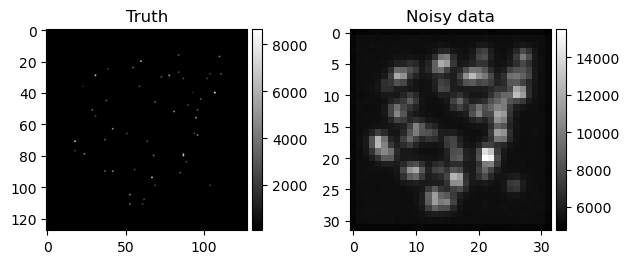

In [7]:
## plot truth and data
fig, ax = plt.subplots(ncols=2)

# truth
im = ax[0].imshow(x_im_truth, cmap='gray')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Truth')
fig.colorbar(im, cax=cax, orientation='vertical')

# data
im = ax[1].imshow(unrav(y, par['s_data']), cmap='gray')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
ax[1].set_title('Noisy data')
fig.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

### Reduced likelihood

In [2], we proposed a method, Certified Coordinate Selection, to reduce the dimension of the problem. In brief, we select the components in $x$ that contribute the most to the posterior, so
$$x = (x_{\mathcal{I}}, x_{\mathcal{I}^C}),$$
where $x_{\mathcal{I}}$ is the selected coordinates. With a proper choose of the set $\mathcal{I}$, the influence of the prior on the posterior are mainly on $x_{\mathcal{I}}$. $x_{\mathcal{I}}$ is computed out of this notebook, and for technical details, we refer the reader to [2].

The $x_{\mathcal{I}}$ is plotted in the following plot as black pixels.

### Smoothed Laplace prior

In [8]:
class LaplaceSmoothed(cuqi.distribution.Distribution):
    def __init__(self, location, scale, beta, **kwargs):
        super().__init__(**kwargs)
        self.location = location
        self.scale = scale
        self.beta = beta
  
    def logpdf(self, x):
        if isinstance(x, (float,int)):
            x = np.array([x])
        return self.dim*(np.log(0.5/self.scale)) - np.sum(np.sqrt((x-self.location)**2+self.beta))/self.scale

    def gradient(self, val):
        if isinstance(val, (float,int)):
            val = np.array([val])
        return -np.array((val - self.location)/self.scale/np.sqrt((val-self.location)**2+self.beta))

    def _sample(self,N=1,rng=None):
        pass

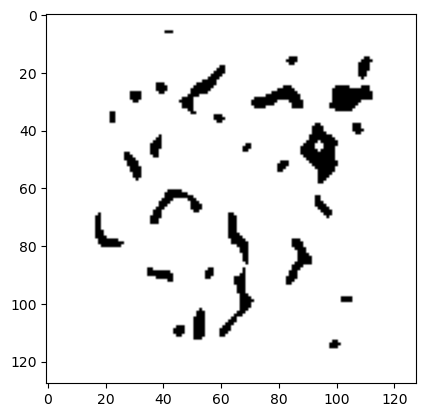

In [9]:
# truth
selected_set = np.load('I.npy')
x_selected_set = np.zeros(x_im_truth.shape)
fig = plt.figure()

temp = rav(x_selected_set)
temp[selected_set] = 1
x_selected_set = unrav(temp, 128)
plt.imshow(x_selected_set, cmap='gray_r')

### Posterior sampling with CUQIpy
With the above description of the smoothed Laplace prior and reduced likelihood, we are now to define them in CUQIpy.

Here we define a `UserDefinedDistribution` by passing by functions `logpdf` and `gradient` from our previous defined `LaplaceSmoothed` object.

In [11]:
# prior
d = len(selected_set) # dimension of the problem after reduction
beta = 1e-5 # smoothing parameter
X = LaplaceSmoothed(location = np.zeros(d), scale=1/par['delta'], beta=beta)

The reduced forward solver can be defined by selecting specific columns of the full matrix. 

In [12]:
A_reduced_mat = A_mat[:,selected_set]
A_reduced = cuqi.model.LinearModel(A_reduced_mat)
Y = Gaussian(A_reduced@X, cov= par['noise_std']**2)

Then we can define our joint distribution and condition it on the data:

In [13]:
# joint distribution of X and Y
X_Y = JointDistribution(X, Y)
print(X_Y)

# posterior X|Y=y (condition X,Y on data y)
p = X_Y(Y=y)

JointDistribution(
    Equation: 
	p(X,Y) = p(X)p(Y|X)
    Densities: 
	X ~ CUQI LaplaceSmoothed.
	Y ~ CUQI Gaussian. Conditioning variables ['X'].
)


With the posterior object `p` defined, we are ready to draw samples from `p`. As the prior is now equipped with gradient method, we can use gradient-based samplers to draw samplers from the posterior. Here we use the Metroplis-adjusted Langevin algorithm (MALA).

In [14]:
nuts_sampler = cuqi.sampler.NUTS(p, max_depth=3)
# nuts_samples = nuts_sampler.sample(10000, 500)
nuts_samples = nuts_sampler.sample(1000, 500)

Sample 1500 / 1500


Selecting 5 randomly chosen variables


array([[<Axes: title={'center': 'X391'}>,
        <Axes: title={'center': 'X391'}>],
       [<Axes: title={'center': 'X453'}>,
        <Axes: title={'center': 'X453'}>],
       [<Axes: title={'center': 'X486'}>,
        <Axes: title={'center': 'X486'}>],
       [<Axes: title={'center': 'X706'}>,
        <Axes: title={'center': 'X706'}>],
       [<Axes: title={'center': 'X732'}>,
        <Axes: title={'center': 'X732'}>]], dtype=object)

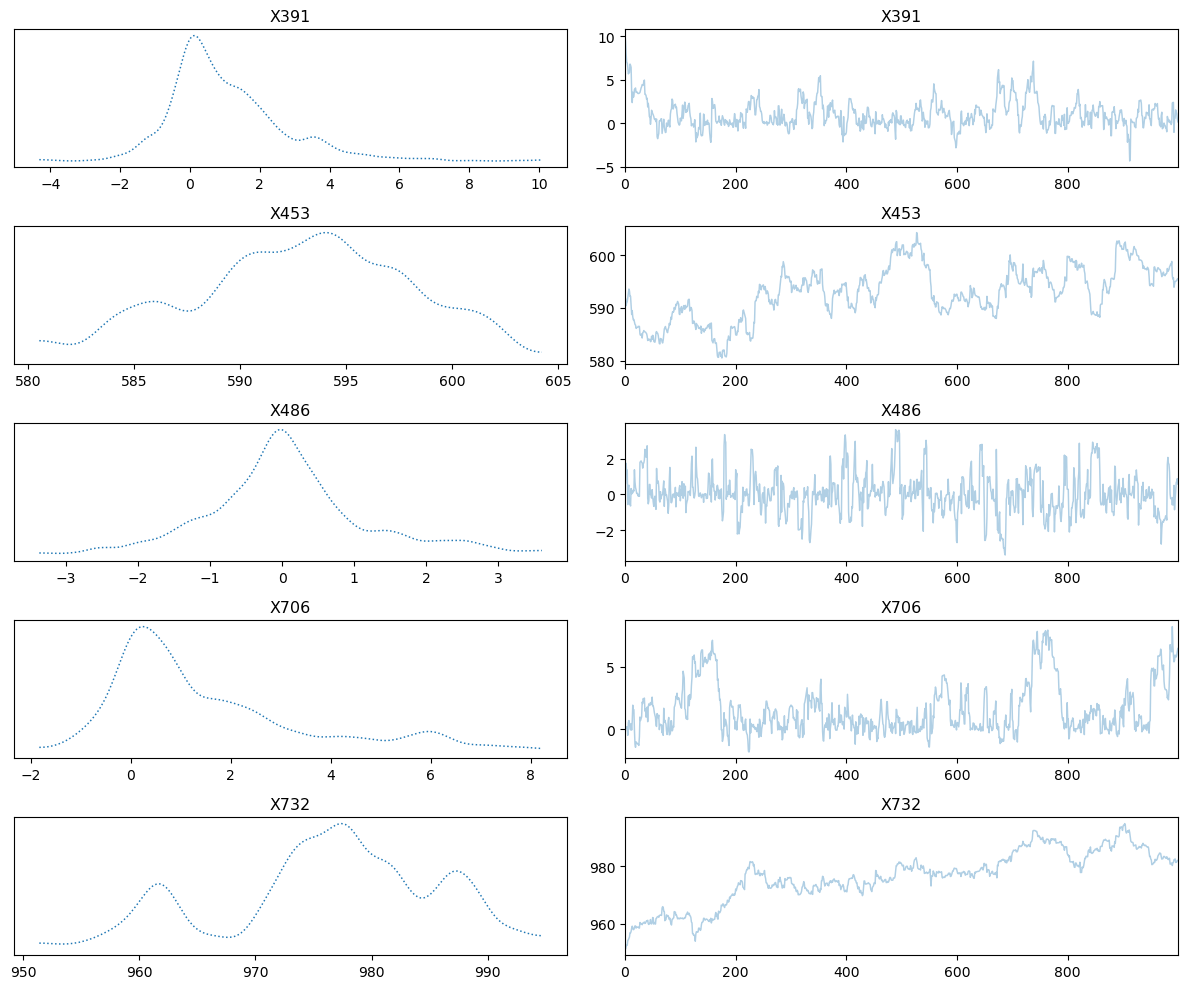

In [15]:
nuts_samples.plot_trace()

Text(0.5, 1.0, 'Posterior mean of NUTS samples')

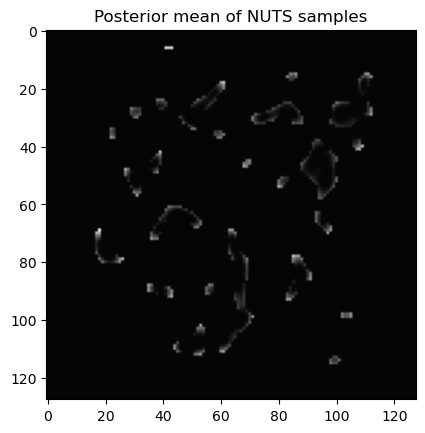

In [16]:
x_post = np.zeros(16384)
x_post[selected_set] = nuts_samples.mean()
plt.imshow(unrav(x_post, 128), cmap='gray')
plt.title("Posterior mean of NUTS samples")

Text(0.5, 1.0, 'The last NUTS sample')

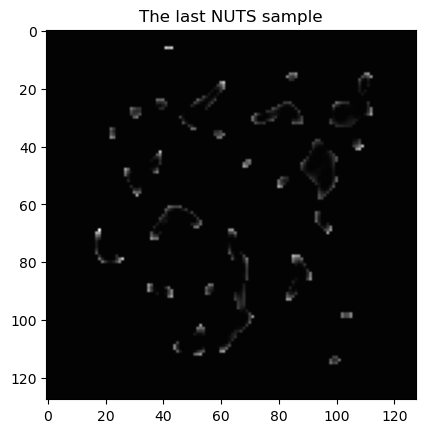

In [17]:
x_laplace = cuqi.distribution.Laplace(np.array([0]), np.array([1/par['delta']]))
x_last_sample = x_laplace.sample(16384).samples.flatten()
x_last_sample[selected_set] = nuts_samples.samples[:,-1]
plt.imshow(unrav(x_last_sample, 128), cmap='gray')
plt.title("The last NUTS sample")

### Sampling and sample statistics

[1]
Zhu, L., Zhang, W., Elnatan, D., Huang, B.: Faster STORM using compressed sensing. Nature Methods 9(7), 721–723 (2012) https://doi.org/10.1038/nmeth.1978

[2]
Flock, R., Dong, Y., Uribe, F., & Zahm, O.: Certified coordinate selection for high-dimensional Bayesian inversion with Laplace prior. Statistics and Computing. Under Review (2023). https://doi.org/10.21203/rs.3.rs-3471448/v1 